<a href="https://colab.research.google.com/github/TheSpaceMan915/Artificial-Intelligence/blob/main/Lab11_Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторная работа №11  Колычев Никита  ВПР34**

In [ ]:
#@title Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop

# **Functions**

Creating an array containing **previous data** and an array containing **future values**

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # changing the shape of the dataset (creating one dimensional array)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

**Plotting a chart**

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  plt.figure(figsize=(7, 5))
  labels = ["History", "True future value", "Prediction"]
  marker = [".-", "rx", "go"]
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i] ,marker[i], markersize=10,
               label=labels[i], color=tuple(np.random.rand(3)))
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], 
               label=labels[i], color=tuple(np.random.rand(3)))
  plt.legend(loc=4)
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel("Time interval")
  return plt

In [ ]:
def plot_train_history(history, title):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, color=tuple(np.random.rand(3)), label="loss")
  plt.plot(epochs, val_loss, color=tuple(np.random.rand(3)), label="val_loss")
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
def multi_step_plot(history, true_future, prediction, step):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label="History")
  plt.plot(np.arange(num_out)/step, np.array(true_future),
           color=tuple(np.random.rand(3)), label="True future value")
  if prediction.any():
    plt.plot(np.arange(num_out)/step, np.array(prediction),
             color=tuple(np.random.rand(3)), label="Prediction")
  plt.legend(loc="upper left")
  plt.show()

# **Data analysis**

In [ ]:
# loading the dataset
path_file = "/content/drive/MyDrive/Colab Notebooks/AI/Datasets/avocado.csv"
df = pd.read_csv(path_file)
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [ ]:
print("shape:", df.shape)

shape: (18249, 14)


array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'AveragePrice'}>,
        <Axes: title={'center': 'Total Volume'}>],
       [<Axes: title={'center': '4046'}>,
        <Axes: title={'center': '4225'}>,
        <Axes: title={'center': '4770'}>],
       [<Axes: title={'center': 'Total Bags'}>,
        <Axes: title={'center': 'Small Bags'}>,
        <Axes: title={'center': 'Large Bags'}>],
       [<Axes: title={'center': 'XLarge Bags'}>,
        <Axes: title={'center': 'year'}>, <Axes: >]], dtype=object)

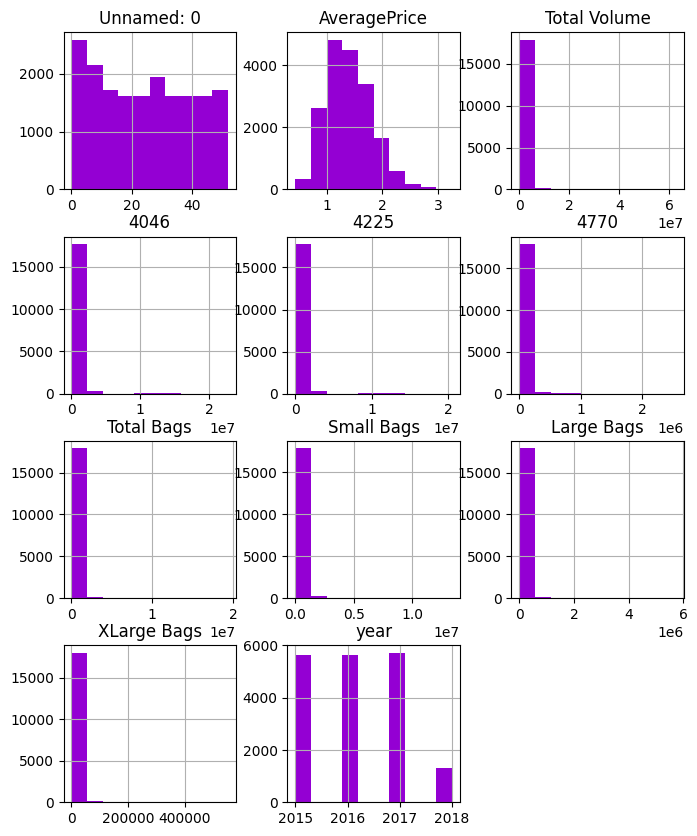

In [ ]:
df.hist(df.columns, figsize=(8, 10), color="darkviolet")

# **Predicting data using one dimensional time series**

In [ ]:
# 70% of the dataset split
TRAIN_SPLIT = 12774
set_seed(1)

In [ ]:
df_filtered = df.filter(["AveragePrice"])
df_filtered.index = df["Date"]
df_filtered.head()

,AveragePrice
Date,
2015-12-27,1.33
2015-12-20,1.35
2015-12-13,0.93
2015-12-06,1.08
2015-11-29,1.28


<Axes: xlabel='Date'>

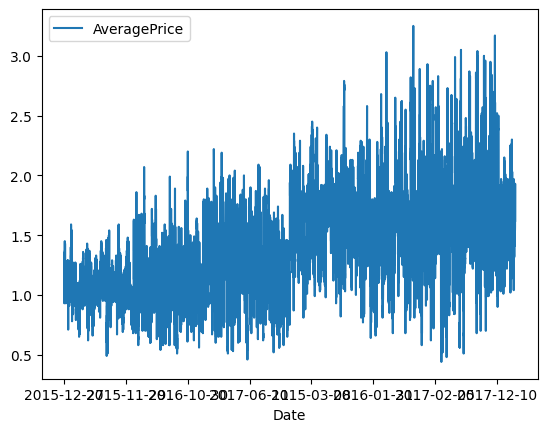

In [ ]:
# data changes during a period of time
df_filtered.plot()

In [ ]:
# standardising the data
arr_data = df_filtered.values
std_arr_data = arr_data[:TRAIN_SPLIT].std()
mean_arr_data = arr_data[:TRAIN_SPLIT].mean()
arr_data = (arr_data - mean_arr_data) / std_arr_data

In [ ]:
# splitting the data
number_previous_rows = 20
future_target = 0

x_train, y_train = univariate_data(arr_data, 0, 
                                   TRAIN_SPLIT, number_previous_rows, 
                                   future_target)

x_validate, y_validate = univariate_data(arr_data, TRAIN_SPLIT, 
                                         None, number_previous_rows, 
                                         future_target)

In [ ]:
print("Previous avocado prices:")
print(x_train[0])

Previous avocado prices:
[[ 0.10241264]
 [ 0.15990414]
 [-1.04741734]
 [-0.6162311 ]
 [-0.04131611]
 [-0.09880761]
 [-0.87494285]
 [-0.9036886 ]
 [-0.7887056 ]
 [-0.64497685]
 [-0.5012481 ]
 [-0.04131611]
 [ 0.04492114]
 [-0.87494285]
 [ 0.10241264]
 [-0.04131611]
 [-0.52999385]
 [-0.64497685]
 [ 0.13115839]
 [ 0.10241264]]


In [ ]:
print("Future avocado price:")
print(y_train[0])

Future avocado price:
[-0.5012481]


# **Baseline method**
Predicting data using **mean value of all previous values**

<ipython-input-24-92be44c4b036>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  plt.plot(future, plot_data[i] ,marker[i], markersize=10,
<ipython-input-24-92be44c4b036>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(future, plot_data[i] ,marker[i], markersize=10,


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

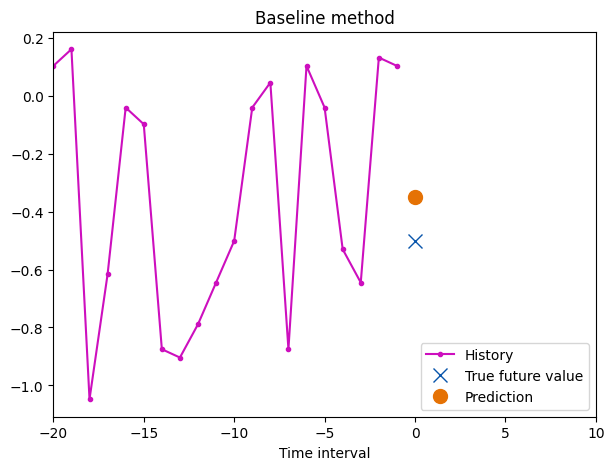

In [ ]:
show_plot([x_train[0], y_train[0], np.mean(x_train[0])], 0, "Baseline method")

# **One LSTM layer**

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

# creating a Dataset object (splitting the data into batches to pass it to LSTM)
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = dataset_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

dataset_validate = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
dataset_validate = dataset_validate.batch(BATCH_SIZE).repeat()

NameError: ignored

In [ ]:
# creating a model containing a LSTM layer
x_train_shape = x_train.shape[-2:]
model = Sequential([
    LSTM(8, input_shape=x_train_shape),
    Dense(1)
])

model.compile(optimizer="adam", loss="mae", metrics=["accuracy"])
print("input shape:", x_train_shape)
print("x_train shape:", x_train.shape)

input shape: (20, 1)
x_train shape: (12754, 20, 1)


In [ ]:
# fitting the model
model.fit(dataset_train, epochs=30, 
          steps_per_epoch=200, validation_data=dataset_validate, 
          validation_steps=50, batch_size=32, 
          verbose=1)

Epoch 1/30
200/200 [==============================] - 3s 14ms/step - loss: 0.2800 - accuracy: 0.0000e+00 - val_loss: 0.4070 - val_accuracy: 0.0000e+00
Epoch 2/30
200/200 [==============================] - 4s 20ms/step - loss: 0.2798 - accuracy: 0.0000e+00 - val_loss: 0.4057 - val_accuracy: 0.0000e+00
Epoch 3/30
200/200 [==============================] - 4s 22ms/step - loss: 0.2799 - accuracy: 0.0000e+00 - val_loss: 0.4065 - val_accuracy: 0.0000e+00
Epoch 4/30
200/200 [==============================] - 5s 24ms/step - loss: 0.2798 - accuracy: 0.0000e+00 - val_loss: 0.4068 - val_accuracy: 0.0000e+00
Epoch 5/30
200/200 [==============================] - 7s 35ms/step - loss: 0.2798 - accuracy: 0.0000e+00 - val_loss: 0.4058 - val_accuracy: 0.0000e+00
Epoch 6/30
200/200 [==============================] - 6s 31ms/step - loss: 0.2796 - accuracy: 0.0000e+00 - val_loss: 0.4059 - val_accuracy: 0.0000e+00
Epoch 7/30
200/200 [==============================] - 5s 26ms/step - loss: 0.2795 - accuracy: 

8/8 [==============================] - 1s 12ms/step


<ipython-input-4-92be44c4b036>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  plt.plot(future, plot_data[i] ,marker[i], markersize=10,
<ipython-input-4-92be44c4b036>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(future, plot_data[i] ,marker[i], markersize=10,


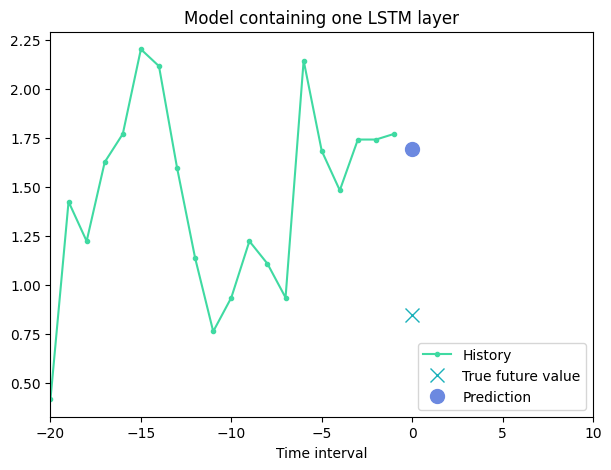

8/8 [==============================] - 0s 9ms/step


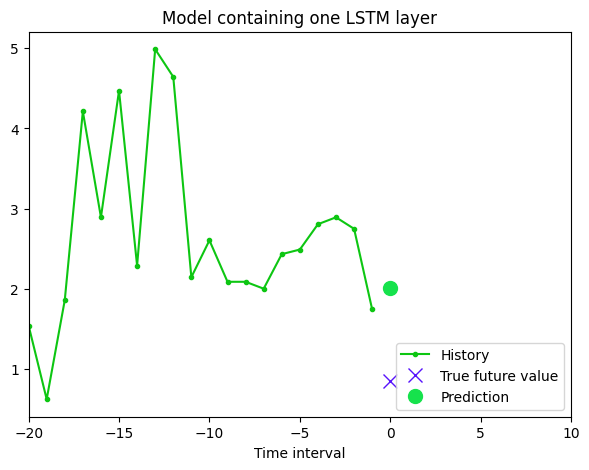

8/8 [==============================] - 0s 8ms/step


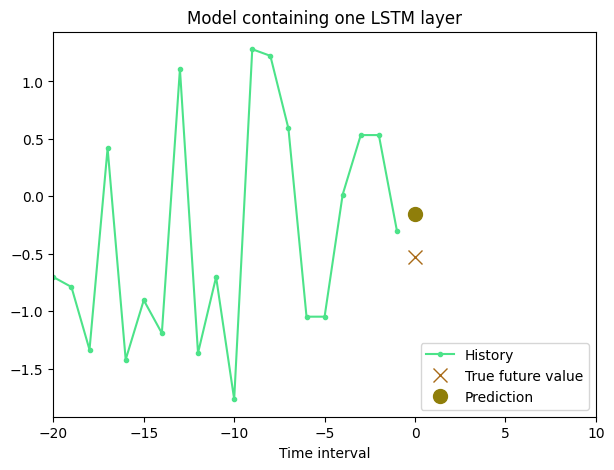

In [ ]:
for x, y in dataset_validate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(), model.predict(x)[0]],
                   0, "Model containing one LSTM layer")
  plot.show()

# **Predicting data using multidimensional time series**

In [ ]:
df_filtered = df.filter(["AveragePrice", "Total Volume", "Total Bags"])
df_filtered.index = df["Date"]
df_filtered.head()

,AveragePrice,Total Volume,Total Bags
Date,,,
2015-12-27,1.33,64236.62,8696.87
2015-12-20,1.35,54876.98,9505.56
2015-12-13,0.93,118220.22,8145.35
2015-12-06,1.08,78992.15,5811.16
2015-11-29,1.28,51039.60,6183.95


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

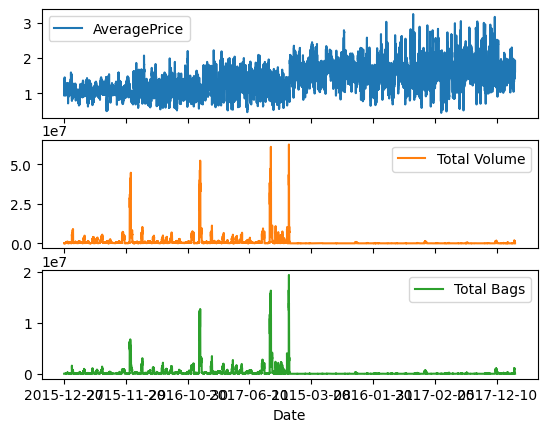

In [ ]:
df_filtered.plot(subplots=True)

# **One-step forecast model**

Predicting only one value in the future

In [ ]:
# standardising the data
arr_data = df_filtered.values
std_arr_data = arr_data[:TRAIN_SPLIT].std(axis=0)
mean_arr_data = arr_data[:TRAIN_SPLIT].mean(axis=0)
arr_data = (arr_data - mean_arr_data) / std_arr_data

In [ ]:
# creating slices to predict an average price of an avocado in a week
number_previous_rows = 1000
future_target = 7
step = 1

x_train, y_train = multivariate_data(arr_data, arr_data[:, 0], 
                                     0, TRAIN_SPLIT, 
                                     number_previous_rows, future_target, 
                                     step, single_step=True)

x_validate, y_validate =  multivariate_data(arr_data, arr_data[:, 0], 
                                            TRAIN_SPLIT, None, 
                                            number_previous_rows, future_target,
                                            step, single_step=True)

In [ ]:
print("time interval:", x_train[0].shape)
print("prediction shape", y_train[0].shape)

time interval: (20, 1)
prediction shape (1,)


In [ ]:
# creating a Dataset object (splitting the data into batches to pass it to LSTM)
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = dataset_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

dataset_validate = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
dataset_validate = dataset_validate.batch(BATCH_SIZE).repeat()

In [ ]:
# creating a model
x_train_shape = x_train.shape[-2:]
model = Sequential([
    LSTM(32, input_shape=x_train_shape),
    Dense(1)
])

model.compile(optimizer="adam", loss="mae")

In [ ]:
# fitting the model
history = model.fit(dataset_train, epochs=10, 
          steps_per_epoch=200, validation_data=dataset_validate, 
          validation_steps=50, verbose=1)

Epoch 1/10
200/200 [==============================] - 182s 899ms/step - loss: 0.5563 - val_loss: 0.8228
Epoch 2/10
200/200 [==============================] - 181s 905ms/step - loss: 0.5185 - val_loss: 0.8023
Epoch 3/10
200/200 [==============================] - 179s 895ms/step - loss: 0.5105 - val_loss: 0.8046
Epoch 4/10
200/200 [==============================] - 182s 910ms/step - loss: 0.5041 - val_loss: 0.8036
Epoch 5/10
200/200 [==============================] - 184s 921ms/step - loss: 0.4909 - val_loss: 0.8131
Epoch 6/10
200/200 [==============================] - 178s 892ms/step - loss: 0.4681 - val_loss: 0.8028
Epoch 7/10
200/200 [==============================] - 179s 896ms/step - loss: 0.4510 - val_loss: 0.8033
Epoch 8/10
200/200 [==============================] - 182s 911ms/step - loss: 0.4386 - val_loss: 0.8181
Epoch 9/10
200/200 [==============================] - 182s 909ms/step - loss: 0.4287 - val_loss: 0.8246
Epoch 10/10
200/200 [==============================] - 202s 1s/s

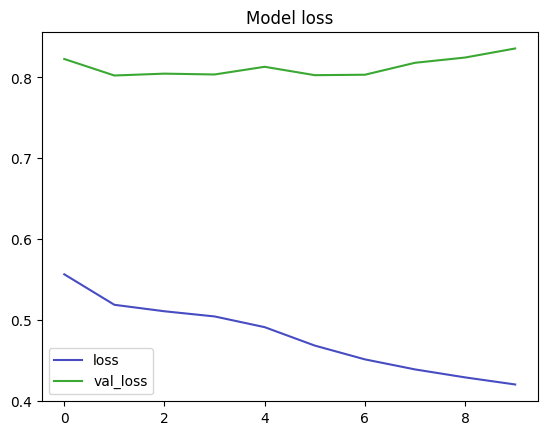

In [ ]:
plot_train_history(history, "Model loss")

8/8 [==============================] - 0s 5ms/step


<ipython-input-24-92be44c4b036>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  plt.plot(future, plot_data[i] ,marker[i], markersize=10,
<ipython-input-24-92be44c4b036>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(future, plot_data[i] ,marker[i], markersize=10,


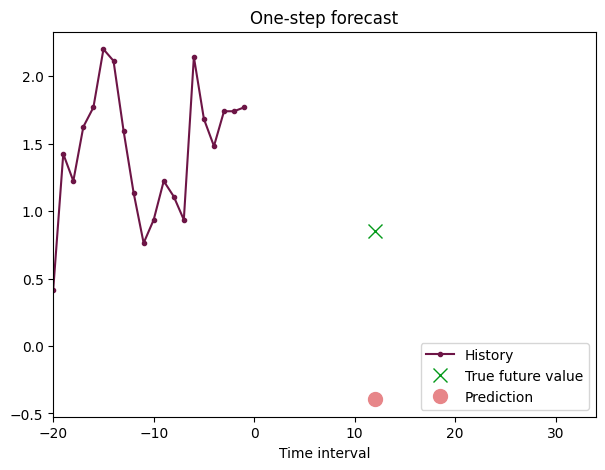

8/8 [==============================] - 0s 4ms/step


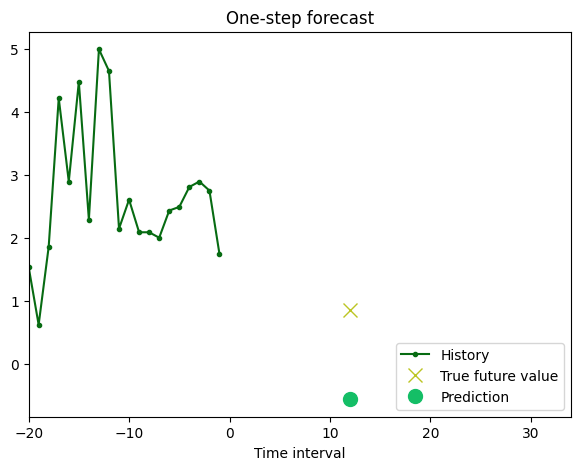

8/8 [==============================] - 0s 3ms/step


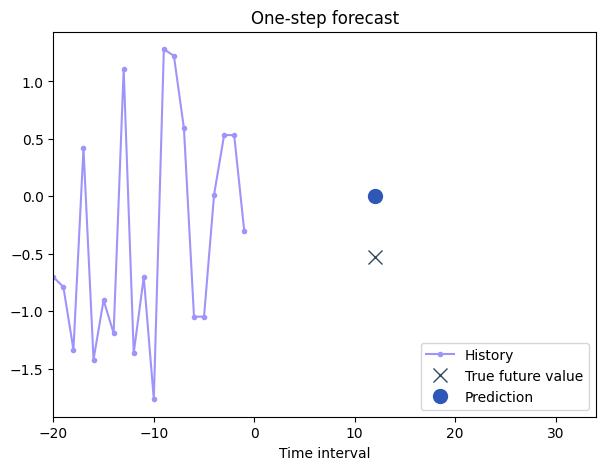

In [ ]:
# plotting charts
for x, y in dataset_validate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(), model.predict(x)[0]],
                   12, "One-step forecast")
  plot.show()

# **Multi-step forecast model**
Predicting a range of values

In [ ]:
# creating slices to predict 7 prices of avocado (for one weeks)
# 120/1 - 120 days (last 4 months)
number_previous_rows = 120
future_target = 7
step = 1

x_train, y_train = multivariate_data(arr_data, arr_data[:, 0], 
                                     0, TRAIN_SPLIT, 
                                     number_previous_rows, future_target, 
                                     step)

x_validate, y_validate =  multivariate_data(arr_data, arr_data[:, 0], 
                                            TRAIN_SPLIT, None, 
                                            number_previous_rows, future_target,
                                            step)

In [ ]:
print("time interval:", x_train[0].shape)
print("prediction shape", y_train[0].shape)

time interval: (120, 3)
prediction shape (7,)


In [ ]:
# creating a Dataset object (splitting the data into batches to pass it to LSTM)
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = dataset_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

dataset_validate = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
dataset_validate = dataset_validate.batch(BATCH_SIZE).repeat()

In [ ]:
# creating a model
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]),
    LSTM(16, activation="relu"),
    Dense(7)
])

rms = RMSprop(clipvalue=1.0)
model.compile(optimizer=rms, loss="mae")

In [ ]:
history = model.fit(dataset_train, epochs=10, 
          steps_per_epoch=200, validation_data=dataset_validate, 
          validation_steps=50, verbose=1)

Epoch 1/10
200/200 [==============================] - 50s 226ms/step - loss: 0.4948 - val_loss: 0.6567
Epoch 2/10
200/200 [==============================] - 52s 260ms/step - loss: 0.4094 - val_loss: 0.6190
Epoch 3/10
200/200 [==============================] - 43s 217ms/step - loss: 0.3984 - val_loss: 0.6050
Epoch 4/10
200/200 [==============================] - 43s 218ms/step - loss: 0.3944 - val_loss: 0.5991
Epoch 5/10
200/200 [==============================] - 48s 242ms/step - loss: 0.3918 - val_loss: 0.6041
Epoch 6/10
200/200 [==============================] - 43s 213ms/step - loss: 0.3875 - val_loss: 0.5963
Epoch 7/10
200/200 [==============================] - 42s 209ms/step - loss: 0.3785 - val_loss: 0.5955
Epoch 8/10
200/200 [==============================] - 41s 206ms/step - loss: 0.3707 - val_loss: 0.6044
Epoch 9/10
200/200 [==============================] - 43s 217ms/step - loss: 0.3652 - val_loss: 0.6026
Epoch 10/10
200/200 [==============================] - 44s 221ms/step - l

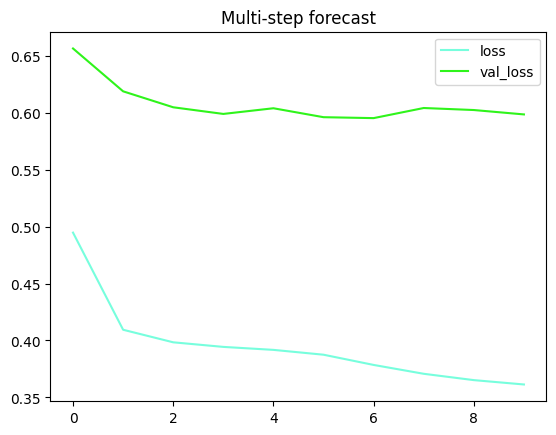

In [ ]:
plot_train_history(history, "Multi-step forecast")